# Forest fire prediction and prevention

Forest fire can be large scale natural disasters and have a great impact on the environment. Early warning and detection can help prevent these 
events, and machine learning models can be helpful in achieving this.

![Forest fire](https://gdb.voanews.com/054f5cb3-1868-4b15-a6a8-7e5717759c0f_w1200_r1.jpg)

In this notebook I will use the [Algerian Forest Fires Dataset Data Set](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) to test 
different types of machine learning models in order to see if it is possible to predict forest fires. 

Data Set Information:

The dataset includes 244 instances that regroup a data of two regions of Algeria,namely the Bejaia region located in the northeast of Algeria and the Sidi Bel-abbes region located in the northwest of Algeria.

122 instances for each region.

The period from June 2012 to September 2012.
The dataset includes 11 attribues and 1 output attribue (class)
The 244 instances have been classified into fire (138 classes) and not fire (106 classes) classes.


Attribute Information:

1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012)
Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH : Relative Humidity in %: 21 to 90
4. Ws :Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8
FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely fire and not fire

# Setup and Importing libraries

In [ ]:
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import plotly.express as px

# import scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBRegressor, XGBClassifier # you may need to install XGBoost
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from yellowbrick.model_selection import learning_curve

# helpers
import sys
sys.path.append(r"C:\Users\terje\DataspellProjects\tub_advanced_ds")
from src.helpers import feature_importance_plot
from src.helper_classes import EDA, Model

sns.set(rc={"figure.figsize": (20,10)})

# EDA

In order to train and test our machine learning model we'll first need to get a better understanding and overview of our data. 
In this section I'll perform an exploratory data analysis.

As we have two variables that indicate forest fire in our dataset, *FWI* and *Classes* I will create models using each as the target variable

In [ ]:
# Using the EDA helper class to load data
forest_fires_fwi = EDA("../data/algerian_forest_fires.csv")
forest_fires_classes = EDA("../data/algerian_forest_fires.csv")

In [ ]:
# Set target variables for both FWI (continious) and for Classes (categorical)
forest_fires_fwi.target("FWI", target_type="cont")
forest_fires_classes.target("Classes", target_type="cat")

## Exploring the data

In this section we'll examine our data with a focus on identifying potential issues for our models.

### Feature columns

We'll start by looking at the complete dataset and examine the features looking at some descriptive statistics and information.

In [ ]:
forest_fires_fwi.info()

We see that we have 243 rows and none of the 13 columns with missing data. All our columns are numerical with a mix of ints and floats expect for our target column *Classes*

In [ ]:
forest_fires_fwi.df.sample(10)

From sampling 10 rows we see that fires occured with a FWI as low as 7.5. We'll investigate this a bit further by checking the FWI
for only days with fire.

In [ ]:
forest_fires_fwi.df[forest_fires_fwi.df["Classes"] == "fire"].sort_values("FWI")

Looking at the days where there was a fire we see that fires took place with the FWI being as low as 1.7.

In [ ]:
forest_fires_fwi.describe()

These are the key descirptives:

- All our data is from 2012 and from the months between June and September.
- The average temperature in these months was 32 degrees, with the min being 22 and max 42.
- The average amount of rain is very low with an average of 0.8 mm per day. It appears most of the rain came on the same day.
- The average FWI was 7, with 75% of days having a FWI lower than 11.5

Seeing as out year column is static, we'll remove it.

In [ ]:
# Check variance for all cols
forest_fires_fwi.df.std().round(2)

In [ ]:
# Remove low variance cols for both fwi and classes instances
forest_fires_fwi.remove_low_variance_cols(threshhold=0.1)

In [ ]:
forest_fires_classes.remove_low_variance_cols(threshhold=0.1)


Using a boxplot we can get a better understanding of the distribution of our data.

In [ ]:
# Map months to month names
months = {"6": "June", "7": "July", "8": "August", "9": "September"}

fig = px.box(forest_fires_fwi.df_clean.drop(columns="Classes"), color="month", 
    title="Boxplot of features")
# Loop over traces and update plot with name from months mapping
fig.for_each_trace(lambda t: t.update(name = months[t.name],
                                      legendgroup = months[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, months[t.name])
                                     )
                  )

We see that there are relatively few outliers in our features. Moreover we see that the ranges are relatively uniform between features, except for DC during september.

In [ ]:
px.imshow(forest_fires_fwi.correlations(), text_auto=True, aspect="auto", width=1000, height=600)

From the correlations plot we see that FFMC, DMC, DC, ISI, BUI and FWI are highly correlated. Since all of these are components of the FWI this makes sense. 
Using these as predictiors for a forest fire might be problematic, however.

### Target columns

Next we'll examine our target columns, FWI and Classes.

#### FWI

FWI is hte Fire Weather Index and ranges from 0-31.1. It is based on midday air temperatures, relative air humidity and wind speeds as well as 24-hour precipitation rates [NWCG.gov](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system). The higher the index the more likely a fire is to occur. The FWI integrates Initial Spread Index (ISI) and BUI (Buildup Index) so these should be highly correlated.

We'll start by looking at the distribution of the FWI.

In [ ]:
# Using the EDA class plot_target method to show distribution
forest_fires_fwi.plot_target()

We see that the distribution of the FWI is right skewed. This makes sense as forest fires are usually not frequent phenomena. 

### Classes

The Classes variable is a binary variable specifying if there was a fire or not. As such, it is a more clear cut predictor than FWI. It is therefore interesting to analyse both, and particularly the correlation between FWI and classes.

We'll start by looking at the distribution and then check the correlation between FWI and Classes.

In [ ]:
forest_fires_classes.plot_target()

We see that the distribution between fire and non fire events are relatively balanced. 

Next we'll investigate the correlation between FWI and Classes

In [ ]:
#forest_fires_classes.df["Classes_dummy"] = forest_fires_classes.df["Classes"].replace({"fire": 1, "not fire": 0})
forest_fires_classes.df["target_dummy"]

In [ ]:
#forest_fires_classes.plot_target_corr(cols=["FWI"])
px.imshow(forest_fires_classes.df[["FWI", "target_dummy"]].corr(), text_auto=True)

We see that as expected FWI and Classes are highly positively correlated.

For our model we'll therefore drop FWI in the features for the Classes model and vice versa.

In [ ]:
forest_fires_fwi.df_clean = forest_fires_fwi.df_clean.drop(columns="Classes")
forest_fires_fwi.df_clean

In [ ]:
forest_fires_classes.df_clean = forest_fires_classes.df_clean.drop(columns="FWI")

# Modelling
Having explored and prepared our dataset, we are ready to train and evaluate our models.

We'll start by the models with FWI as target.

## FWI

In [ ]:
fwi_models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]
fwi_fitted_models = {}
fwi_feature_importances = {}
fwi_model_scores = pd.DataFrame(index=["R2", "MAE", "MSE"])

for model in fwi_models:
    m = Model(forest_fires_fwi.target_var, forest_fires_fwi.df_clean, model)
    m.evaluate_model(type="reg", plot_learning_curve=False)
    fwi_fitted_models[m.model_name] = m
    fwi_feature_importances[m.model_name] = m.model.feature_importances_
    fwi_model_scores = pd.merge(fwi_model_scores, m.scores, left_index=True, right_index=True)

In [ ]:
fwi_model_scores.sort_index(ascending=False)

In [ ]:
for model in fwi_fitted_models.values():
    model.feature_importance_plot()

Seeing as most of our variables are correlated with our target variable I will also check how our model performs with these removed.

In [ ]:
# Removing highly correlated variables.
forest_fires_fwi.remove_highly_corr()

In [ ]:
fwi_models = [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()]
fwi_fitted_models = {}
fwi_feature_importances = {}
fwi_model_scores = pd.DataFrame(index=["R2", "MAE", "MSE"])

for model in fwi_models:
    m = Model(forest_fires_fwi.target_var, forest_fires_fwi.df_clean, model)
    m.evaluate_model(type="reg", plot_learning_curve=True)
    fwi_fitted_models[m.model_name] = m
    fwi_feature_importances[m.model_name] = m.model.feature_importances_
    fwi_model_scores = pd.merge(fwi_model_scores, m.scores, left_index=True, right_index=True)

In [ ]:
fwi_model_scores

## Classes

In [ ]:
classes_models = [DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]
classes_fitted_models = {}
classes_feature_importances = {}
classes_model_scores = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])

for model in classes_models:
    m = Model(forest_fires_classes.target_var, forest_fires_classes.df_clean, model)
    m.evaluate_model(type="class", plot_learning_curve=False)
    classes_fitted_models[m.model_name] = m.model
    classes_feature_importances[m.model_name] = m.model.feature_importances_
    classes_model_scores = pd.merge(classes_model_scores, m.scores, left_index=True, right_index=True)

In [ ]:
classes_model_scores.sort_index(ascending=False)

In [ ]:
forest_fires_classes.remove_highly_corr()

X_train shape (194, 4)
X_test shape (49, 4)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 1 0]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.7346938775510204
Precision: 0.8181818181818182
Recall: 0.6666666666666666
F1: 0.7346938775510203
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'splitter']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'splitter']) 


dict_keys(['

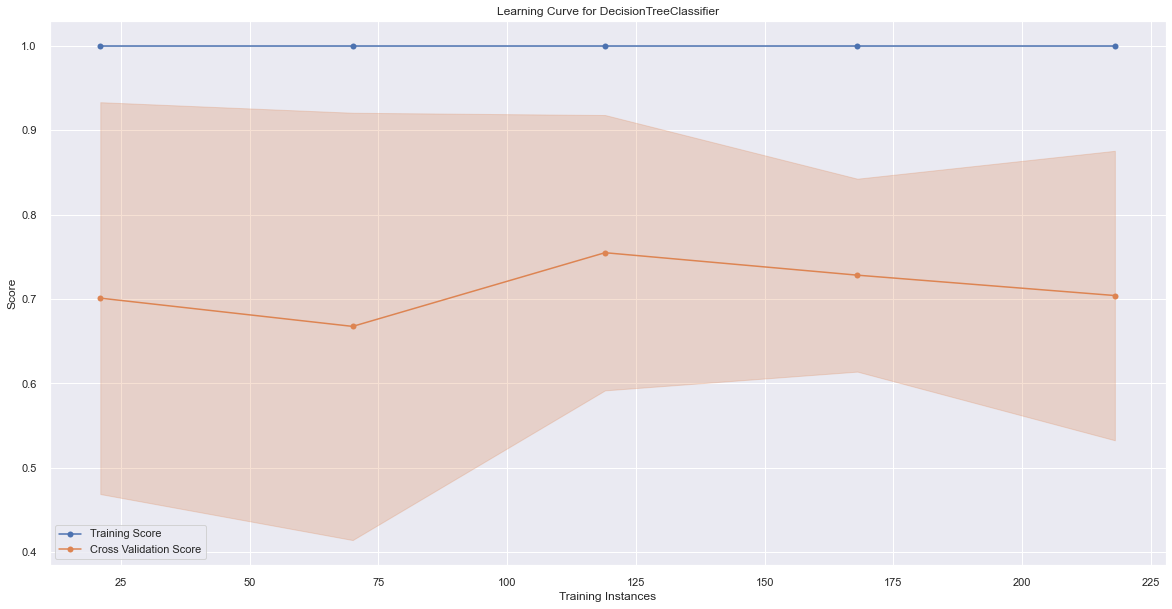

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'splitter']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'splitter']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf

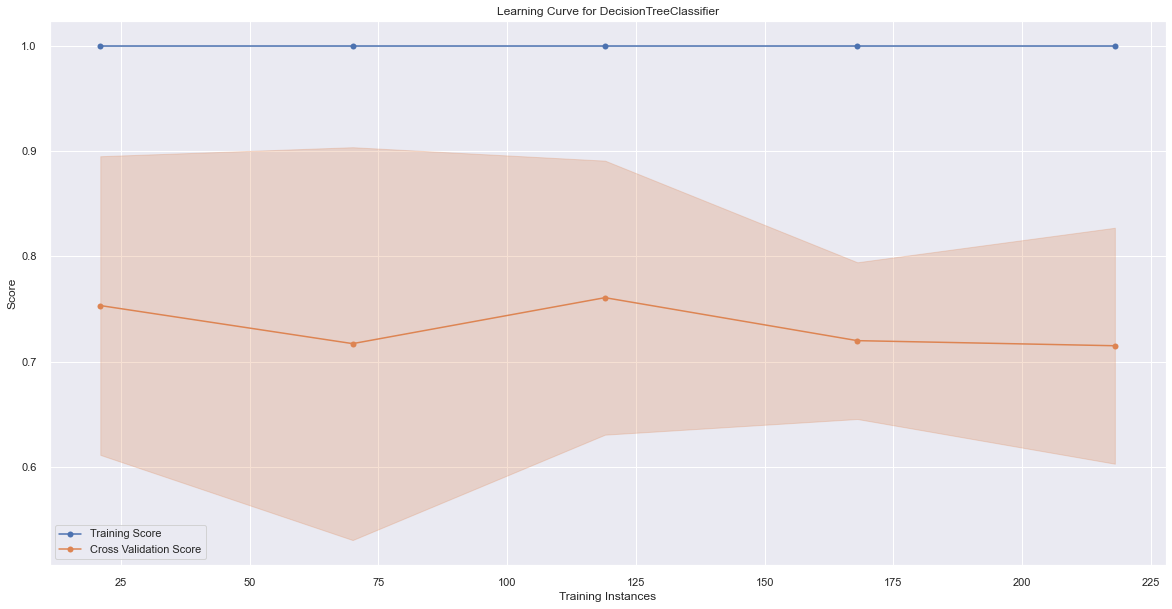

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'splitter']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'splitter']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf

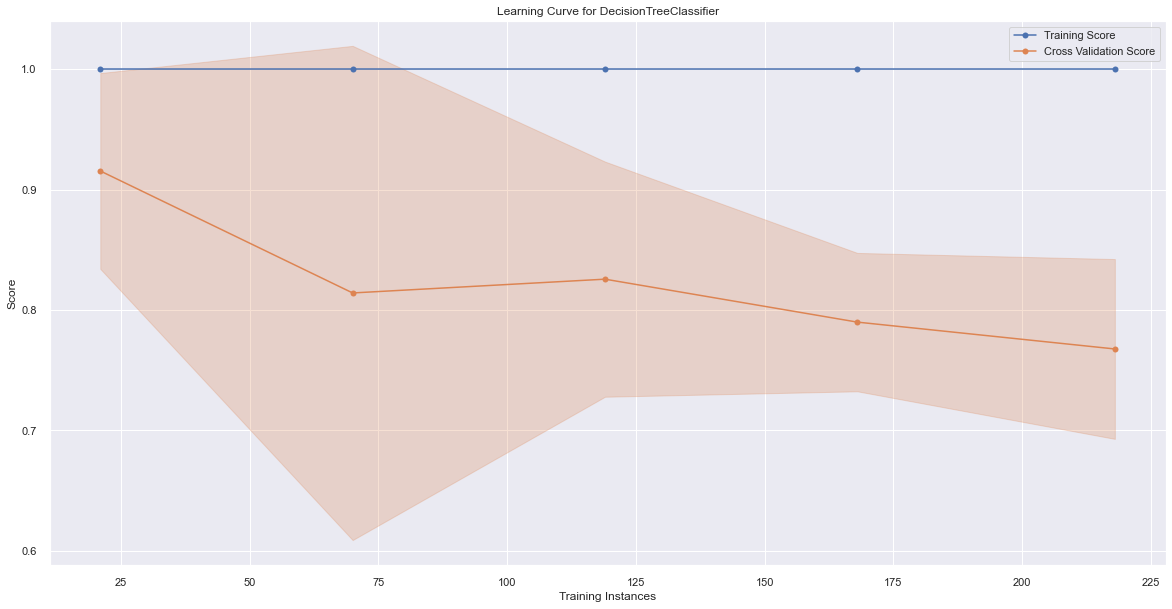

X_train shape (194, 4)
X_test shape (49, 4)
y_train shape (194,)
y_test shape (49,)
first five predicted values: [1 1 0 0 1]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.8163265306122449
Precision: 0.8461538461538461
Recall: 0.8148148148148148
F1: 0.830188679245283
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 

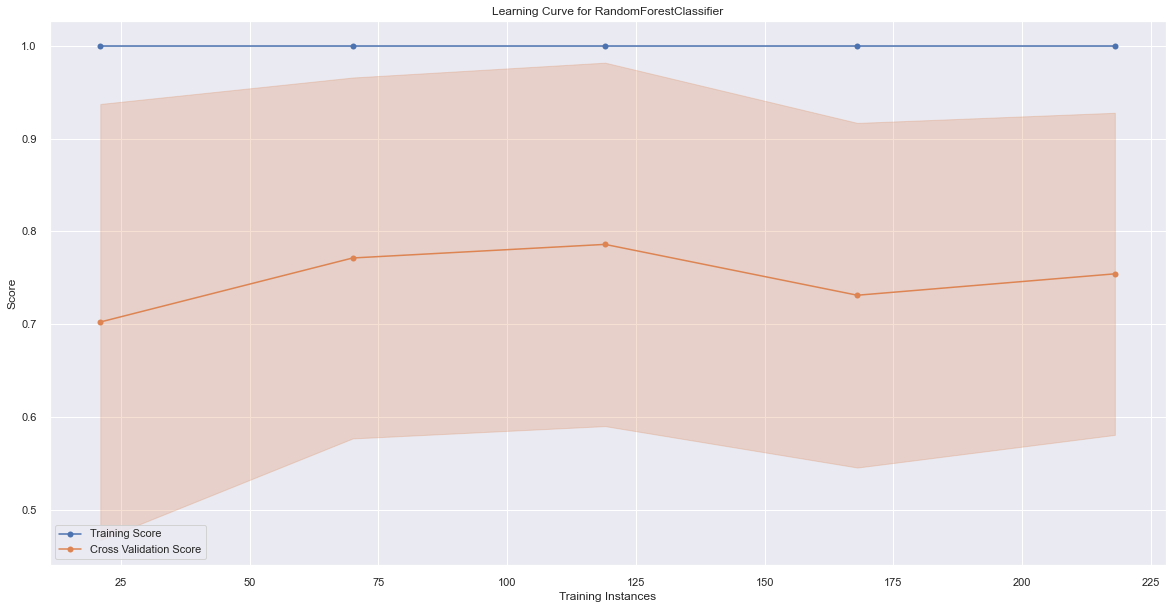

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

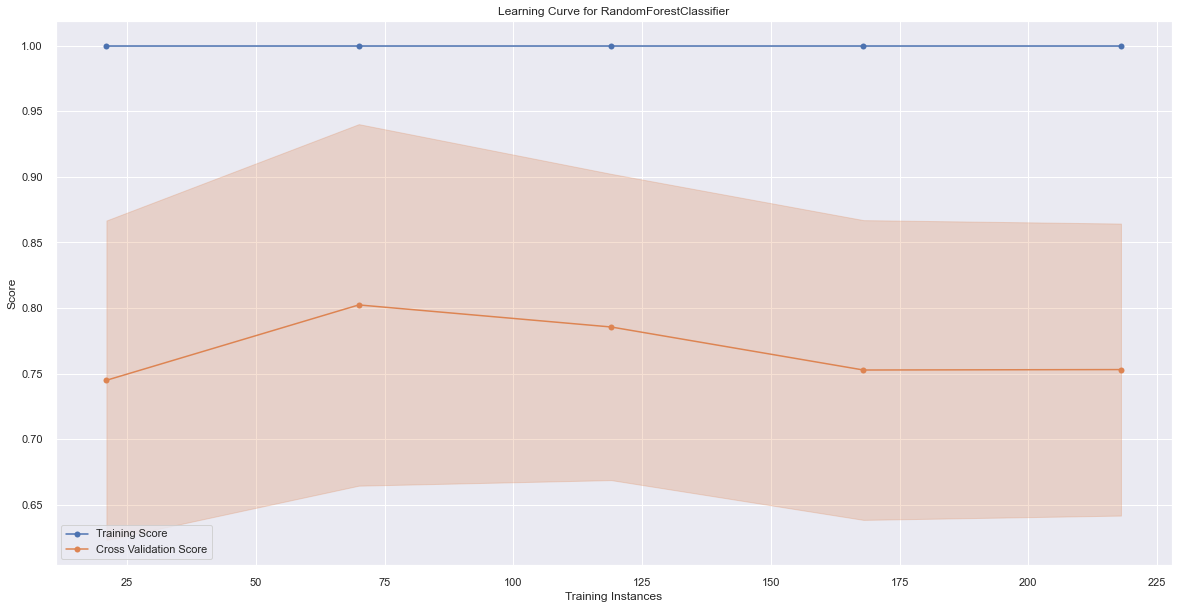

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'oob_score', 'verbose', 'warm_start']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train

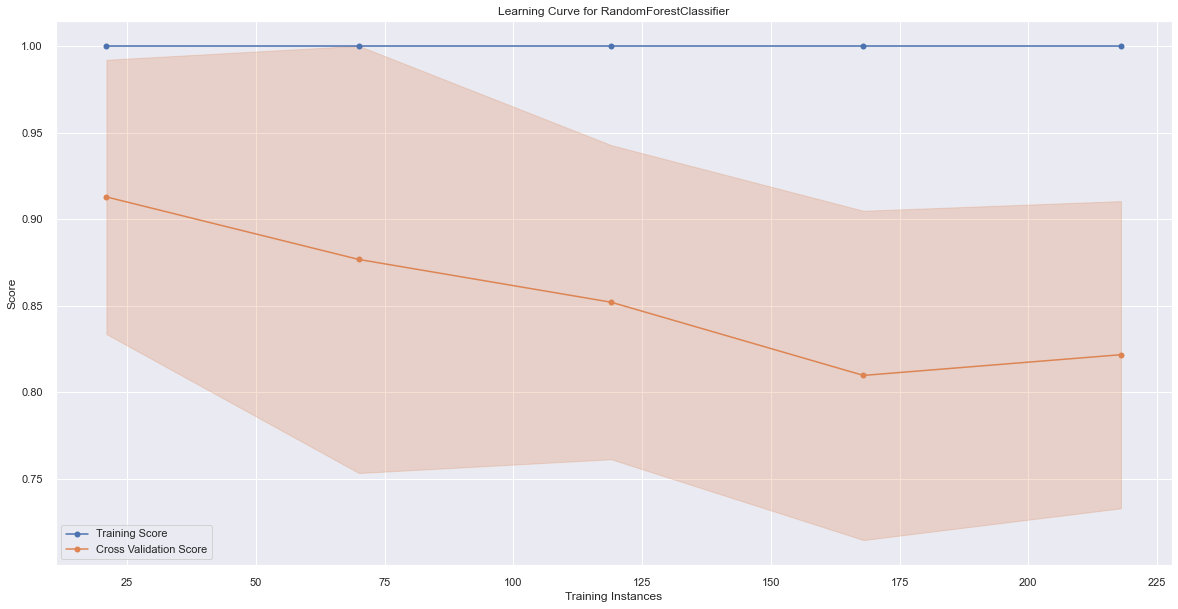

X_train shape (194, 4)
X_test shape (49, 4)
y_train shape (194,)
y_test shape (49,)
[17:03:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
first five predicted values: [1 1 0 0 0]
first five actual values: [1, 1, 0, 0, 1]
Accuracy: 0.7346938775510204
Precision: 0.7916666666666666
Recall: 0.7037037037037037
F1: 0.7450980392156864
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_es

c:\Users\terje\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\Users\terje\miniconda3\lib\site-packages\joblib\externals\loky\backend\utils.py:55: UserWarning:

Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil



BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

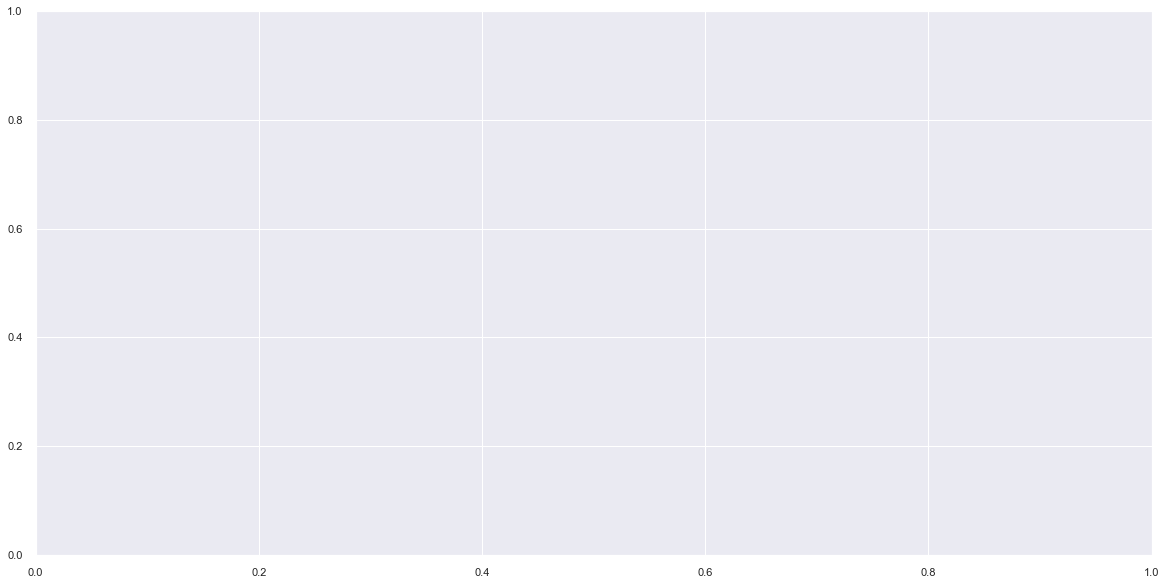

In [41]:
classes_models = [DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]
classes_fitted_models = {}
classes_feature_importances = {}
classes_model_scores = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"])

for model in classes_models:
    m = Model(forest_fires_classes.target_var, forest_fires_classes.df_clean, model)
    m.evaluate_model(type="class", plot_learning_curve=True)
    classes_fitted_models[m.model_name] = m.model
    classes_feature_importances[m.model_name] = m.model.feature_importances_
    classes_model_scores = pd.merge(classes_model_scores, m.scores, left_index=True, right_index=True)

In [42]:
classes_model_scores

,DecisionTreeClassifier,RandomForestClassifier
Accuracy,0.734694,0.816327
Precision,0.818182,0.846154
Recall,0.666667,0.814815
F1,0.734694,0.830189
